In [24]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from models.dit import DiT
from models import *
from tqdm import tqdm
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc
)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### 테스트 데이터셋 클래스 정의

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path, header=None)

        label_map = {label: idx for idx, label in enumerate(df.iloc[:, 0].unique())}
        df.iloc[:, 0] = df.iloc[:, 0].map(label_map)

        self.X = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(df.iloc[:, 0].values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### 데이터 로드

In [4]:
test_dataset = TimeSeriesDataset("C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Test_with_anomaly.csv")
test_loader = DataLoader(test_dataset, batch_size=64)

#### 모델 불러오기

In [5]:
model = DiT(input_size=750, patch_size=5, in_channels=1, num_classes=42).to(device)
model.load_state_dict(torch.load("dit_ts_model.pt", map_location=device))
model.eval()

C:\Users\Pro\AppData\Local\Temp\ipykernel_25116\1507463972.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dit_ts_model.pt", map_locati

DiT(
  (label_emb): Embedding(42, 512)
  (x_embedder): PatchEmbed(
    (proj): Conv1d(1, 512, kernel_size=(5,), stride=(5,))
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (y_embedder): ConditionEmbedder(
    (proj): PatchEmbed(
      (proj): Conv1d(1, 512, kernel_size=(5,), stride=(5,))
    )
    (pool): AdaptiveAvgPool1d(output_size=1)
    (linear): Linear(in_features=512, out_features=512, bias=True)
  )
  (blocks): ModuleList(
    (0-27): 28 x DiTBlock(
      (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=512, out_features=1536, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (proj_drop): Dro

#### 예측 평균 기반 이상 감지 평가

In [27]:
pred_scores = []   # 예측 평균값
true_labels = []   # 0=정상, 1=이상

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Evaluating", unit="batch"):
        x = x.to(device)
        t = torch.zeros(x.size(0), dtype=torch.long).to(device)

        out = model(x, t, y.to(device))  # (B, 2, 750)
        mean_out = out[:, 0, :]          # 평균 채널만 사용

        # 정상 구간 평균값 (t < 500)
        normal_mean = mean_out[:, :500].mean(dim=1)
        pred_scores.extend(normal_mean.cpu().tolist())
        true_labels.extend([0] * x.size(0))

        # 이상 구간 평균값 (t ≥ 500)
        anomaly_mean = mean_out[:, 500:].mean(dim=1)
        pred_scores.extend(anomaly_mean.cpu().tolist())
        true_labels.extend([1] * x.size(0))

Evaluating: 100%|██████████| 62/62 [03:17<00:00,  3.18s/batch]


In [28]:
pred_scores = np.array(pred_scores)
true_labels = np.array(true_labels)

#### PR Curve, ROC Curve

In [29]:
precision, recall, thresholds_pr = precision_recall_curve(true_labels, pred_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_idx]

fpr, tpr, thresholds_roc = roc_curve(true_labels, pred_scores)
roc_auc = auc(fpr, tpr)

#### 최적 threshold 적용 및 평가

In [30]:
pred_labels = (pred_scores > best_threshold).astype(int)
print(f"🔍 F1-score 기준 최적 threshold: {best_threshold:.4f}")
print(classification_report(true_labels, pred_labels, target_names=["정상", "이상"]))

🔍 F1-score 기준 최적 threshold: 0.1461
              precision    recall  f1-score   support

          정상       1.00      1.00      1.00      3930
          이상       1.00      1.00      1.00      3930

    accuracy                           1.00      7860
   macro avg       1.00      1.00      1.00      7860
weighted avg       1.00      1.00      1.00      7860



#### 시각화: PR Curve & ROC Curve

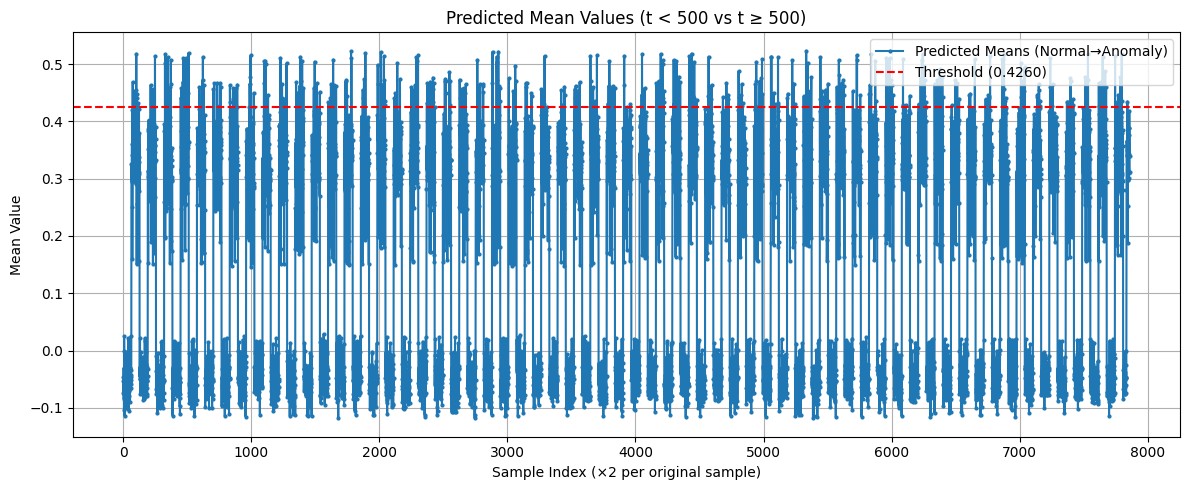

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(pred_means, label="Predicted Means (Normal→Anomaly)", marker='o', linestyle='-', markersize=2)
plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold ({threshold:.4f})")
plt.title("Predicted Mean Values (t < 500 vs t ≥ 500)")
plt.xlabel("Sample Index (×2 per original sample)")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 이전

In [5]:
train = pd.read_csv('C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Train_with_anomaly.csv', sep='\t', index_col=False, header=None)
test = pd.read_csv('C:/Users/Pro/Desktop/AnomalyDiT-main/AnomalyDiT-main/Dataset/ECG_Test_with_anomaly.csv', sep='\t', index_col=None, header=None)

In [6]:
train = torch.Tensor(train.drop(columns=0).to_numpy()).unsqueeze(1)
test = torch.Tensor(test.drop(columns=0).to_numpy()).unsqueeze(1)

In [7]:
test.shape

torch.Size([3930, 1, 0])

In [8]:
net = DiT(input_size=750,
        patch_size=5,
        in_channels=1,
        hidden_size=300,
        depth=28,
        num_heads=10,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        learn_sigma=False,)

In [9]:
x = torch.randn(4,1,750)
y = test[:4]
t = torch.randint(low=0, high=10000, size=(4,))